# Setup

In [8]:
# Imports #
import os
import torch
import pandas as pd
import tempfile
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, ssdlite320_mobilenet_v3_large

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [ ]:
## Define Variables ##

# COCO 80 classes (excluding __background__)
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Common COCO-BDD classes
COMMON_CLASSES = [
    "person", "car", "truck", "bus", "train", "motorcycle", "bicycle", "traffic light"
]

font = ImageFont.load_default()

# Compare Models on a single image
1. Ground Truth
2. YOLO
3. Faster R-CNN
4. SSD

In [ ]:
# Helper Functions #
def yolo_txt_to_boxes(txt_path, img_w, img_h, class_names, filter_classes=None):
    boxes, labels = [], []
    if not os.path.exists(txt_path):
        print(f"[Warning] GT file {txt_path} not found.")
        return boxes, labels

    with open(txt_path, "r") as f:
        for line in f.readlines():
            cls, x_c, y_c, w, h = map(float, line.strip().split())
            cls = int(cls)
            label = class_names[cls]
            if filter_classes and label not in filter_classes:
                continue
            xmin = (x_c - w / 2) * img_w
            xmax = (x_c + w / 2) * img_w
            ymin = (y_c - h / 2) * img_h
            ymax = (y_c + h / 2) * img_h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
    return boxes, labels

def draw_boxes(image, boxes, labels=None, color="green"):
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    for i, box in enumerate(boxes):
        draw.rectangle(box, outline=color, width=2)
        if labels:
            draw.text((box[0], box[1] - 10), str(labels[i]), fill=color, font=font)
    return img_copy

def run_inference(model, image, class_names, filter_classes=None, conf_thresh=0.5):
    img_copy = image.copy()
    tensor = F.to_tensor(img_copy).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        preds = model(tensor)[0]

    draw = ImageDraw.Draw(img_copy)
    records = []
    for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
        if score > conf_thresh:
            cls_name = class_names[label - 1] if 0 < label <= len(class_names) else f"Label {label}"
            if filter_classes and cls_name not in filter_classes:
                continue
            bbox = bbox.tolist()
            records.append([cls_name, float(score), bbox])
            draw.rectangle(bbox, outline="red", width=2)
            draw.text((bbox[0], bbox[1] - 10), f"{cls_name}: {score:.2f}", fill="red", font=font)

    df = pd.DataFrame(records, columns=["Class", "Confidence", "BBox [xmin, ymin, xmax, ymax]"])
    return img_copy, df


image 1/1 c:\Users\prves\My_Data\03_Projects\2508_bdd100k_assignment\notebooks\..\dataset\bdd_yolo\images\val\b1c9c847-3bda4659.jpg: 384x640 6 cars, 1 bus, 156.7ms
Speed: 2.3ms preprocess, 156.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_

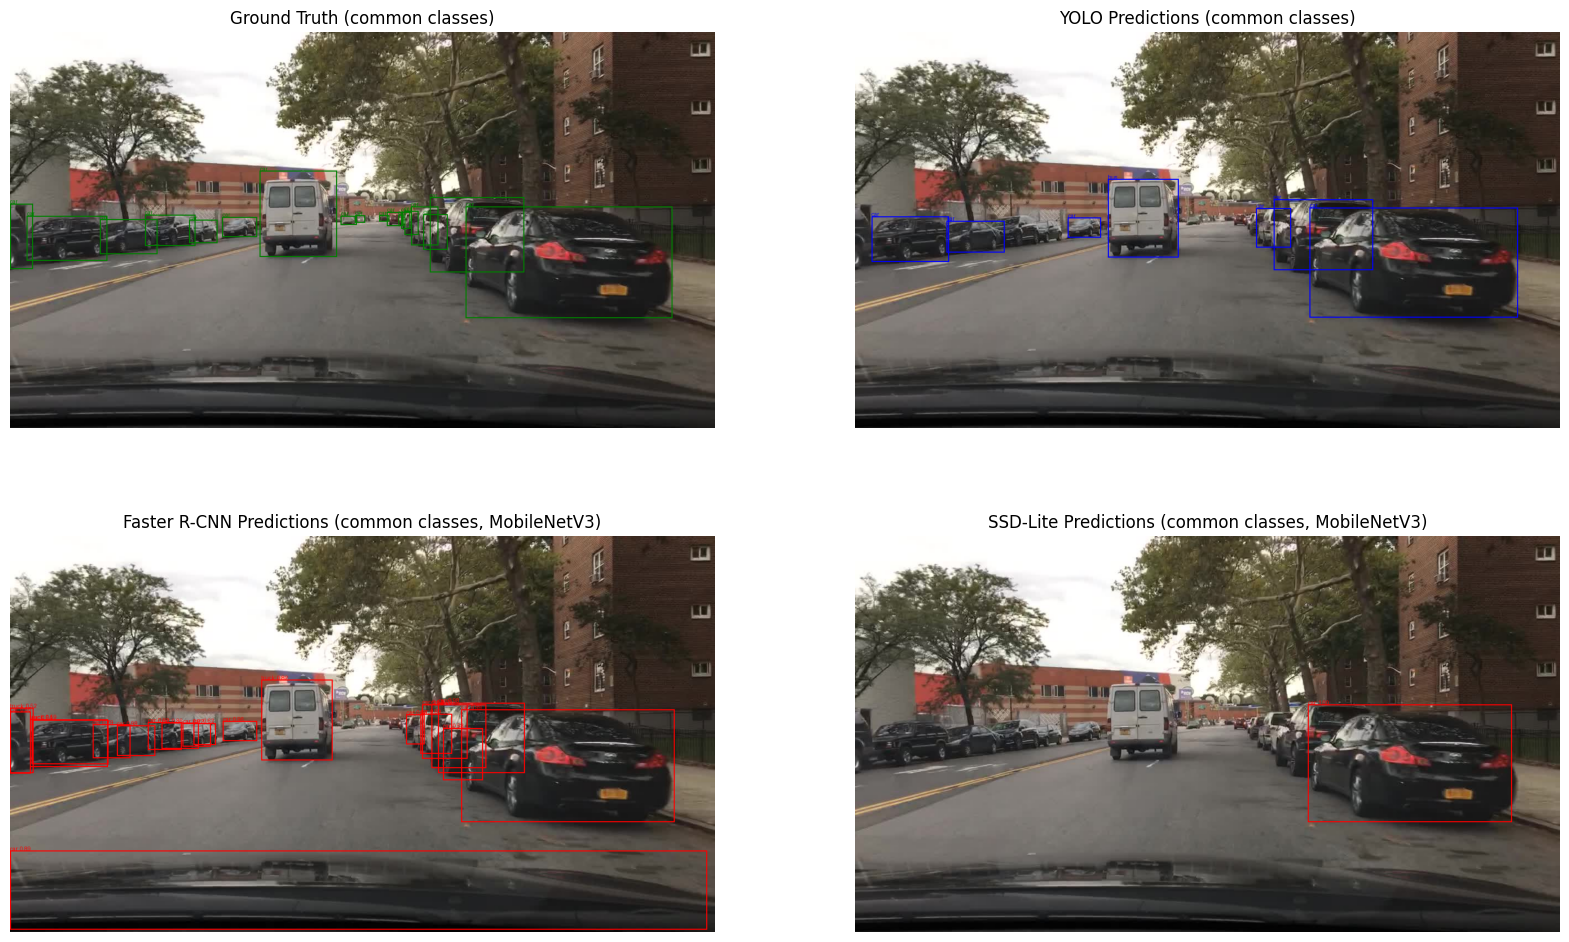


===== Ground Truth =====
   Class Confidence                      BBox [xmin, ymin, xmax, ymax]
0    car        N/A  [325.72672, 342.94356, 376.6784, 384.096599999...
1    car        N/A  [245.38048, 333.14508, 336.50496000000004, 389...
2    car        N/A       [163.07328, 341.96364, 267.91552, 404.67348]
3    car        N/A  [30.794879999999996, 335.10456000000005, 176.7...
4    car        N/A  [626.95744, 334.12536, 644.59456, 347.84279999...
5    car        N/A  [684.7673599999998, 328.2462, 713.18208, 353.7...
6    car        N/A  [705.48416, 333.0054, 714.3020799999999, 353.5...
7    car        N/A  [710.38336, 328.10616000000005, 726.0608000000...
8    car        N/A  [716.26176, 326.14668, 741.7376, 369.259559999...
9    car        N/A  [728.0198399999999, 318.30768, 777.01184, 388....
10   car        N/A  [750.5568000000001, 332.02547999999996, 794.64...
11   car        N/A  [762.31424, 301.65084, 933.7855999999999, 437....
12   car        N/A  [827.6838399999999, 318.30732,

In [ ]:
# =====================
# Load input image + GT labels
# =====================
img_path = "../dataset/bdd_yolo/images/val/b1c9c847-3bda4659.jpg"
label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
image = Image.open(img_path).convert("RGB")
img_w, img_h = image.size

# Ground Truth (YOLO txt)
gt_boxes, gt_labels = yolo_txt_to_boxes(label_path, img_w, img_h, class_names=COCO_CLASSES, filter_classes=COMMON_CLASSES)
gt_img = draw_boxes(image, gt_boxes, gt_labels, color="green")
gt_df = pd.DataFrame({"Class": gt_labels, "Confidence": ["N/A"] * len(gt_labels), "BBox [xmin, ymin, xmax, ymax]": gt_boxes})

# =====================
# YOLO Predictions
# =====================
yolo_model = YOLO("yolov8n.pt")
results = yolo_model(img_path, conf=0.5)[0]

yolo_boxes, yolo_labels, yolo_scores = [], [], []
for box in results.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    cls = int(box.cls)
    cls_name = COCO_CLASSES[cls]
    if cls_name not in COMMON_CLASSES:
        continue
    score = float(box.conf)
    yolo_boxes.append([x1, y1, x2, y2])
    yolo_labels.append(cls_name)
    yolo_scores.append(score)
yolo_img = draw_boxes(image, yolo_boxes, yolo_labels, color="blue")
yolo_df = pd.DataFrame({"Class": yolo_labels, "Confidence": yolo_scores, "BBox [xmin, ymin, xmax, ymax]": yolo_boxes})

# =====================
# Faster R-CNN (MobileNetV3 Lightweight)
# =====================
faster_rcnn = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
faster_img, faster_df = run_inference(faster_rcnn, image, COCO_CLASSES, filter_classes=COMMON_CLASSES)

# =====================
# SSD-Lite (MobileNetV3 Lightweight)
# =====================
ssd = ssdlite320_mobilenet_v3_large(pretrained=True)
ssd_img, ssd_df = run_inference(ssd, image, COCO_CLASSES, filter_classes=COMMON_CLASSES)

# =====================
# Show all results
# =====================
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.title("Ground Truth (common classes)")
plt.imshow(gt_img)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("YOLO Predictions (common classes)")
plt.imshow(yolo_img)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Faster R-CNN Predictions (common classes, MobileNetV3)")
plt.imshow(faster_img)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("SSD-Lite Predictions (common classes, MobileNetV3)")
plt.imshow(ssd_img)
plt.axis("off")

plt.show()

# =====================
# Show summary tables
# =====================
print("\n===== Ground Truth =====")
print(gt_df)

print("\n===== YOLO Predictions =====")
print(yolo_df)

print("\n===== Faster R-CNN Predictions =====")
print(faster_df)

print("\n===== SSD-Lite Predictions =====")
print(ssd_df)


# Evaluate Models on the Validation Set

In [ ]:
# Map COCO/YOLO indices → restricted classes
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

COCO_TO_COMMON = {COCO_CLASSES.index(c): i for i, c in enumerate(COMMON_CLASSES) if c in COCO_CLASSES}

In [ ]:
# =====================
# Helper Functions
# =====================
def yolo_to_xyxy(box, img_w, img_h):
    cx, cy, w, h = box
    cx, cy, w, h = cx * img_w, cy * img_h, w * img_w, h * img_h
    x1, y1 = cx - w/2, cy - h/2
    x2, y2 = cx + w/2, cy + h/2
    return [x1, y1, x2, y2]

def load_yolo_labels(txt_file, img_w, img_h):
    gts = {"boxes": [], "labels": []}
    with open(txt_file, "r") as f:
        for line in f:
            cls, cx, cy, w, h = map(float, line.strip().split())
            cls = int(cls)
            if cls < len(COMMON_CLASSES):
                gts["labels"].append(cls)
                gts["boxes"].append(yolo_to_xyxy([cx, cy, w, h], img_w, img_h))
    gts["boxes"] = torch.tensor(gts["boxes"], dtype=torch.float32)
    gts["labels"] = torch.tensor(gts["labels"], dtype=torch.int64)
    return gts

def preds_to_torchmetrics(preds, class_map, conf_thresh=0.5):
    out = {"boxes": [], "scores": [], "labels": []}
    for box, score, label in zip(preds["boxes"], preds["scores"], preds["labels"]):
        if score > conf_thresh and label.item() in class_map:
            out["boxes"].append(box)
            out["scores"].append(score)
            out["labels"].append(class_map[label.item()])
    if len(out["boxes"]) == 0:
        out["boxes"] = torch.zeros((0, 4))
        out["scores"] = torch.zeros((0,))
        out["labels"] = torch.zeros((0,), dtype=torch.int64)
    else:
        out["boxes"] = torch.stack(out["boxes"])
        out["scores"] = torch.stack(out["scores"])
        out["labels"] = torch.tensor(out["labels"], dtype=torch.int64)
    return out

def yolo_preds_to_torchmetrics(results, class_names):
    out = {"boxes": [], "scores": [], "labels": []}
    for box, conf, cls in zip(results.boxes.xyxy, results.boxes.conf, results.boxes.cls):
        cls = int(cls.item())
        if cls < len(class_names):
            out["boxes"].append(box)
            out["scores"].append(conf)
            out["labels"].append(cls)
    if len(out["boxes"]) == 0:
        out["boxes"] = torch.zeros((0, 4))
        out["scores"] = torch.zeros((0,))
        out["labels"] = torch.zeros((0,), dtype=torch.int64)
    else:
        out["boxes"] = torch.stack(out["boxes"])
        out["scores"] = torch.stack(out["scores"])
        out["labels"] = torch.tensor(out["labels"], dtype=torch.int64)
    return out

def print_results(map_obj, model_name):
    res = map_obj.compute()
    print(f"\n===== {model_name} Results =====")

    # Safe access
    overall_map = res.get('map', float('nan'))
    map_50 = res.get('map_50', float('nan'))
    map_75 = res.get('map_75', float('nan'))

    print(f"mAP@0.5:0.95 : {overall_map:.4f}")
    print(f"mAP@0.5      : {map_50:.4f}")
    print(f"mAP@0.75     : {map_75:.4f}")

    # Per-class AP
    if "map_per_class" in res and "classes" in res:
        print("\nPer-class AP:")
        for cls_idx, ap in zip(res["classes"], res["map_per_class"]):
            cls_name = COMMON_CLASSES[cls_idx]
            print(f"{cls_name:12s} | AP: {ap:.4f}")

def get_model_size_mb(model):
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / 1e6
    os.remove(tmp.name)
    return size_mb

In [ ]:
# =====================
# Load Lightweight Models
# =====================
yolo_model = YOLO("yolov8n.pt")  # ~3M params
faster_model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True).eval()  # ~10-15M
ssd_model = ssdlite320_mobilenet_v3_large(pretrained=True).eval()          # ~6-7M

# =====================
# Model Sizes & Parameters
# =====================
print("\n===== Model Sizes and Parameters =====")
print(f"YOLOv8n     : ~3M params, size on disk: {os.path.getsize('yolov8n.pt')/1e6:.2f} MB")
print(f"Faster R-CNN: ~{sum(p.numel() for p in faster_model.parameters())/1e6:.1f}M params, size: {get_model_size_mb(faster_model):.2f} MB")
print(f"SSD-Lite    : ~{sum(p.numel() for p in ssd_model.parameters())/1e6:.1f}M params, size: {get_model_size_mb(ssd_model):.2f} MB")

# =====================
# Metrics
# =====================
map_yolo = MeanAveragePrecision(class_metrics=True)
map_frcnn = MeanAveragePrecision(class_metrics=True)
map_ssd   = MeanAveragePrecision(class_metrics=True)

# =====================
# Validation Loop with Progress Bar
# =====================
val_img_dir = "../dataset/bdd_yolo/images/val"
val_lbl_dir = "../dataset/bdd_yolo/labels/val"
img_files = [f for f in os.listdir(val_img_dir) if f.endswith(".jpg")]

for img_file in tqdm(img_files, desc="Evaluating images"):
    img_path = os.path.join(val_img_dir, img_file)
    lbl_path = os.path.join(val_lbl_dir, img_file.replace(".jpg", ".txt"))

    image = Image.open(img_path).convert("RGB")
    w, h = image.size
    tensor = F.to_tensor(image).unsqueeze(0)

    # Ground truth
    gt_dict = load_yolo_labels(lbl_path, w, h)

    # ---- YOLO ----
    results = yolo_model(img_path, verbose=False)[0]
    pred_yolo = yolo_preds_to_torchmetrics(results, COMMON_CLASSES)
    map_yolo.update([pred_yolo], [gt_dict])

    # ---- Faster R-CNN ----
    with torch.no_grad():
        preds_frcnn = faster_model(tensor)[0]
    pred_frcnn = preds_to_torchmetrics(preds_frcnn, COCO_TO_COMMON)
    map_frcnn.update([pred_frcnn], [gt_dict])

    # ---- SSD-Lite ----
    with torch.no_grad():
        preds_ssd = ssd_model(tensor)[0]
    pred_ssd = preds_to_torchmetrics(preds_ssd, COCO_TO_COMMON)
    map_ssd.update([pred_ssd], [gt_dict])

# =====================
# Print Final Results
# =====================
print_results(map_yolo, "YOLOv8n")
print_results(map_frcnn, "Faster R-CNN (MobileNetV3)")
print_results(map_ssd, "SSD-Lite (MobileNetV3)")


c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\prves\anaconda3\envs\ml_py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_


===== Model Sizes and Parameters =====
YOLOv8n     : ~3M params, size on disk: 6.55 MB
Faster R-CNN: ~19.4M params, size: 77.84 MB
SSD-Lite    : ~3.4M params, size: 14.06 MB


Evaluating images:   0%|          | 12/10000 [00:10<2:24:39,  1.15it/s]


KeyboardInterrupt: 

In [ ]:
# ===== YOLO 8n Results ===== #
#                  Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [13:20<00:00,  1.28s/it]
#                    all      10000     148372      0.289      0.162      0.175     0.0903
#                 person       3220      13262      0.522      0.363      0.367      0.176
#                bicycle        578       1007      0.503      0.157      0.188     0.0793
#                    car       9879     102506      0.593      0.453      0.498      0.289
#             motorcycle        334        452       0.31      0.157      0.138     0.0636
#                    bus         14         15          0          0   4.15e-05   2.32e-05
#                  train       2689       4245     0.0923    0.00565     0.0329     0.0241
#                  truck       5653      26885          0          0   9.22e-05   3.39e-05

# ===== YOLO 8m Results ===== #
#                  Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [2:15:07<00:00, 12.97s/it]   
#                    all      10000     148372      0.373      0.258      0.275      0.147
#                 person       3220      13262      0.667      0.491      0.527      0.263
#                bicycle        578       1007      0.626       0.32       0.37      0.174
#                    car       9879     102506      0.728      0.556      0.636      0.384
#             motorcycle        334        452      0.494      0.372      0.355      0.182
#                    bus         14         15   0.000561     0.0667   0.000218   0.000131
#                  train       2689       4245     0.0965     0.0033     0.0348     0.0258
#                  truck       5653      26885          0          0   0.000194   6.56e-05

# ===== Faster R-CNN Results ===== #
# WAS TOO BIG TO RUN

# ===== SSD-Lite (MobileNetV3) Results =====
# mAP@0.5:0.95 : 0.0024
# mAP@0.5      : 0.0033
# mAP@0.75     : 0.0021

# Per-class AP:
# person       | AP: 0.0125
# car          | AP: 0.0000
# truck        | AP: 0.0036
# bus          | AP: 0.0000
# train        | AP: 0.0027
# motorcycle   | AP: 0.0000
# bicycle      | AP: 0.0000
# traffic light | AP: 0.0003